In [205]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from scipy.stats import zscore, shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors
import pingouin as pg
import joblib

In [160]:
df_salario = pd.read_csv('./Datasets/dataset_salarios.csv')

In [161]:
df_salario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempo_na_empresa  1000 non-null   int64  
 1   nivel_na_empresa  1000 non-null   int64  
 2   salario_em_reais  1000 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 23.6 KB


In [162]:
#Copiar df para df EDA 
df_salario_eda = df_salario.copy()

In [163]:
df_salario_bucketing = df_salario.copy()

### EDA

In [164]:
#Visualizar os dados
df_salario_eda.head(10)

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
0,50,1,2288.13
1,49,4,2389.84
2,39,10,2158.73
3,51,1,2341.06
4,62,7,3584.20
5,105,10,12102.18
6,80,3,5723.35
7,85,2,6424.92
8,66,5,3916.18
9,73,5,4751.79


In [165]:
#Detectar valores ausentes
df_salario_eda.isna().sum()

tempo_na_empresa    0
nivel_na_empresa    0
salario_em_reais    0
dtype: int64

In [166]:
# Medidas estatisticas do df
df_salario_eda.describe()

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
count,1000.000000,1000.000000,1000.000000
mean,59.712000,5.467000,5093.726110
std,34.027679,2.889509,4536.168857
min,1.000000,1.000000,538.560000
25%,30.750000,3.000000,1537.477500
50%,60.000000,6.000000,3237.920000
75%,89.000000,8.000000,7436.680000
max,120.000000,10.000000,18923.230000


<Axes: xlabel='tempo_na_empresa'>

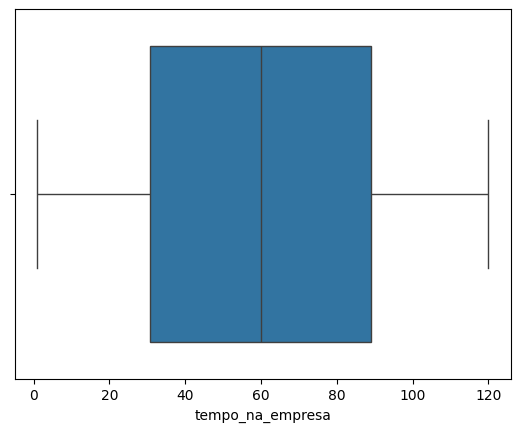

In [167]:
#Detectar outliers
sns.boxplot(data=df_salario_eda, x='tempo_na_empresa')

<Axes: xlabel='nivel_na_empresa'>

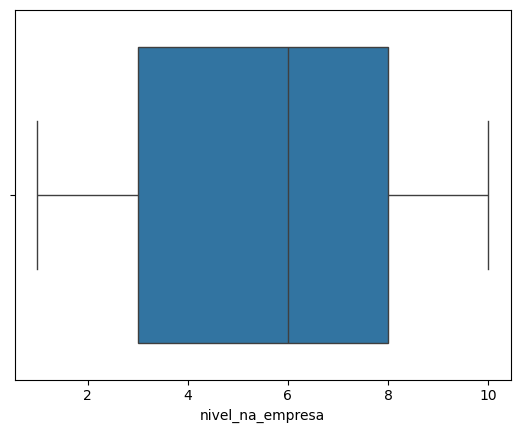

In [168]:
sns.boxplot(data=df_salario_eda, x='nivel_na_empresa')

<Axes: xlabel='salario_em_reais'>

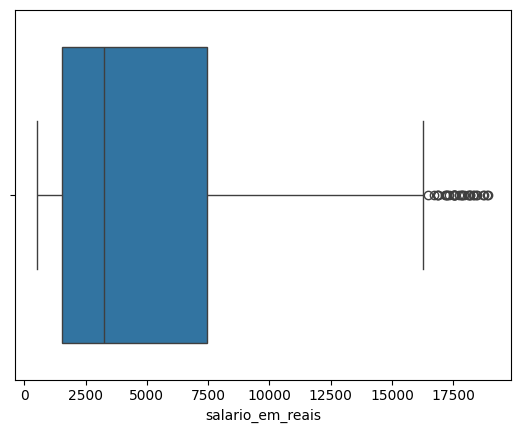

In [169]:
sns.boxplot(data=df_salario_eda, x='salario_em_reais')

<Axes: xlabel='tempo_na_empresa', ylabel='salario_em_reais'>

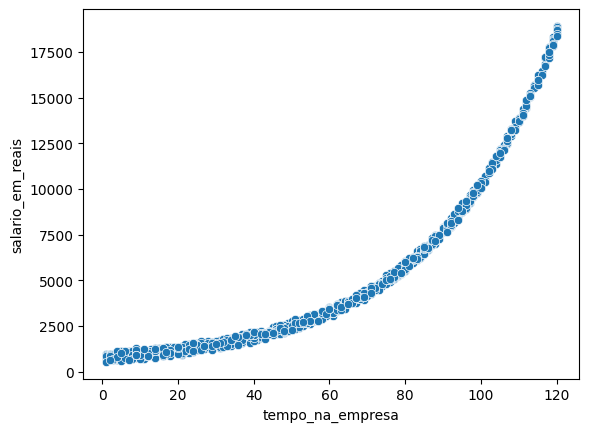

In [170]:
#Cruzamento variaveis numericas com salario em reais
sns.scatterplot(data=df_salario_eda, x='tempo_na_empresa', y='salario_em_reais')

<Axes: xlabel='nivel_na_empresa', ylabel='salario_em_reais'>

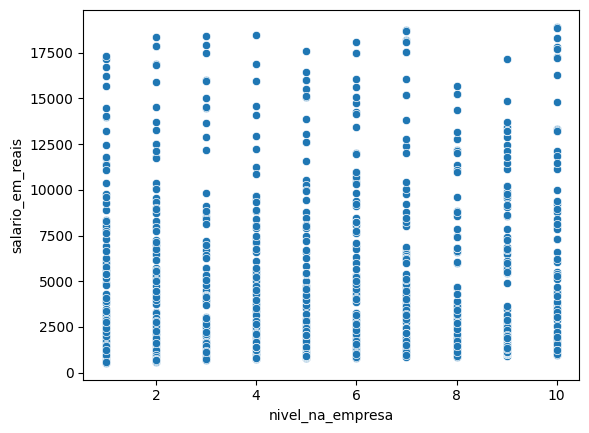

In [171]:
sns.scatterplot(data=df_salario_eda, x='nivel_na_empresa', y='salario_em_reais')

<Axes: xlabel='nivel_na_empresa', ylabel='tempo_na_empresa'>

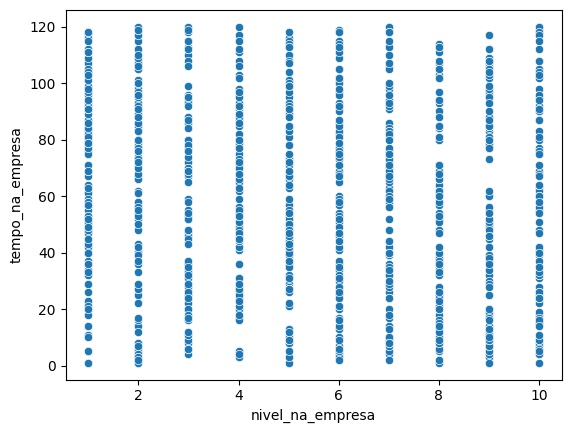

In [172]:
sns.scatterplot(data=df_salario_eda, x='nivel_na_empresa', y='tempo_na_empresa')

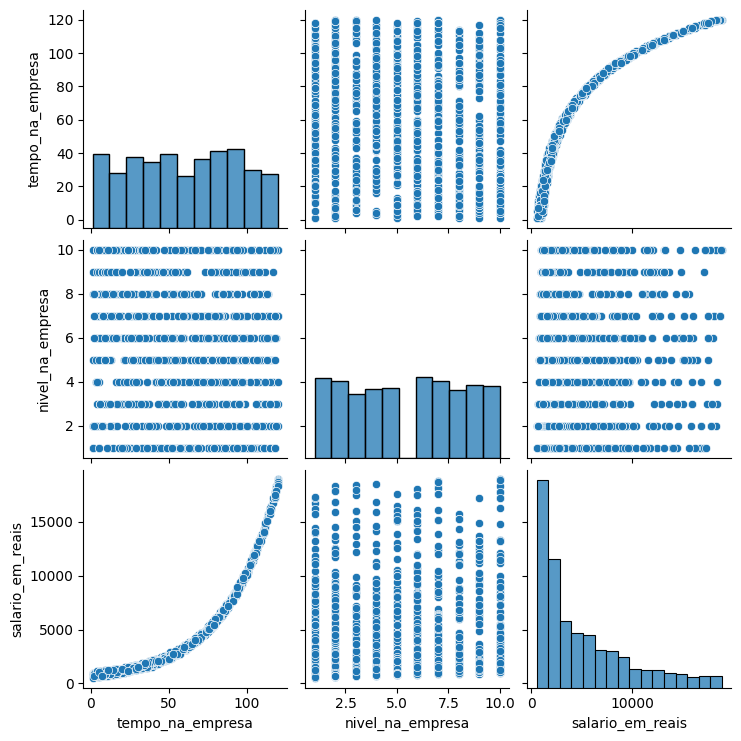

In [173]:
#Histograma das variaveis
sns.pairplot(df_salario_eda)

<Axes: >

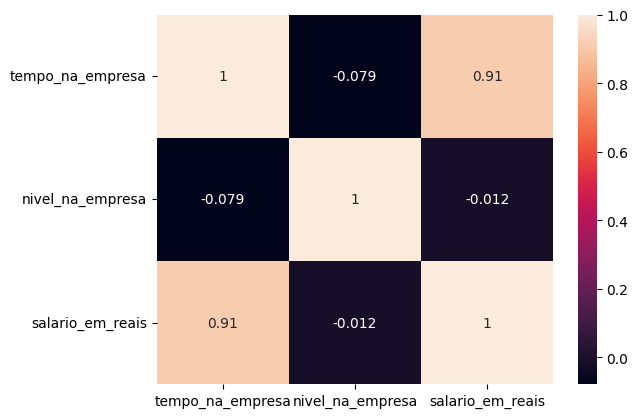

In [174]:
sns.heatmap(df_salario_eda.corr('pearson'), annot=True)

<Axes: >

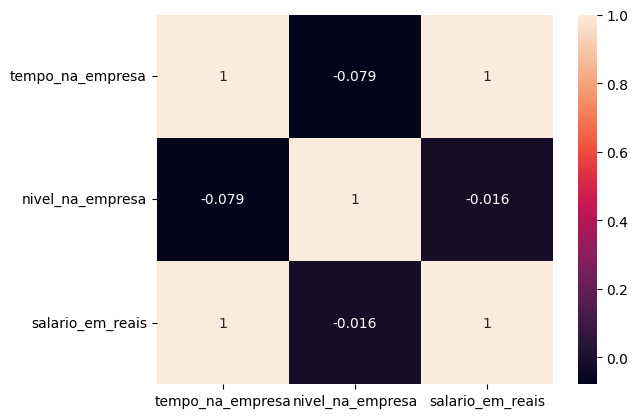

In [175]:
sns.heatmap(df_salario_eda.corr('spearman'), annot=True)

<Axes: >

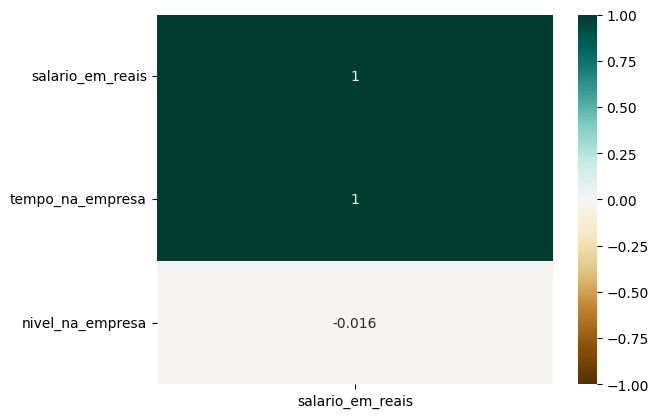

In [176]:
#Formato de rankin
sns.heatmap(df_salario_eda.corr('spearman')[['salario_em_reais']].sort_values(by='salario_em_reais', ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG" )

In [177]:
#bucketing tempo de casa
bins = [0,10,20,30,40,50,60,70,80,90,100,110,120,130]
labels =  ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99','100-109','110-119','120-129']
df_salario_bucketing['escala_tempo'] = pd.cut(x=df_salario_bucketing['tempo_na_empresa'], bins=bins, labels=labels, include_lowest=True)

In [178]:
df_salario_bucketing.head(20)

,tempo_na_empresa,nivel_na_empresa,salario_em_reais,escala_tempo
0,50,1,2288.13,40-49
1,49,4,2389.84,40-49
2,39,10,2158.73,30-39
3,51,1,2341.06,50-59
4,62,7,3584.20,60-69
5,105,10,12102.18,100-109
6,80,3,5723.35,70-79
7,85,2,6424.92,80-89
8,66,5,3916.18,60-69
9,73,5,4751.79,70-79


<Axes: xlabel='escala_tempo', ylabel='salario_em_reais'>

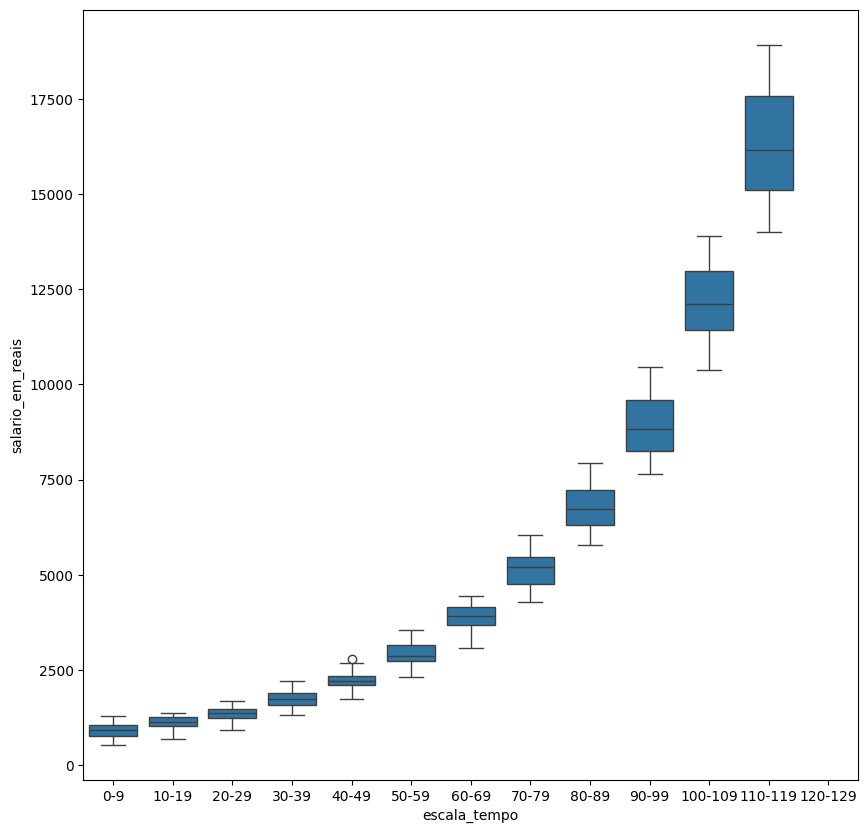

In [179]:
plt.figure(figsize=(10,10))
sns.boxplot(df_salario_bucketing, x='escala_tempo', y='salario_em_reais')

### Treinar modelo linear

In [180]:
#Criar dataset de treino e teste
X = df_salario.drop(columns='salario_em_reais', axis=1)
y = df_salario.salario_em_reais

In [181]:
#Split usando kfold com 5 pastas/splits
kf = KFold(n_splits=5,shuffle=True, random_state=51)

In [182]:
kf

KFold(n_splits=5, random_state=51, shuffle=True)

In [183]:
#Bloco para treinamento do modelo

#Pipeline
#Padronizar variaveis numericas - tempo na empresa, nivel na empresa

#Nomes das colunas
colunas_numericas = ['tempo_na_empresa','nivel_na_empresa']

#Transformer para colunas numericas
transformer_numericas = Pipeline(steps=[('scaler',StandardScaler()) ])

#Criar um Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numericas, colunas_numericas)
    ]
)

#Criando o Pipeline principal - Preprocessamento + Treinamento
model_linear = Pipeline(steps =[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
    ])

#Armazenas RMSE treino e teste (root mean squared error)
rmse_scores_fold_train = []
rmse_scores_fold_teste = []

#Armazenar o r2-score de teste
r2_score_fold_test = []

#Armazenar Residuos
residuos = []

#Armazenar predições
y_pred_total = []

#iteração separação de modelo em x e y train e test
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #Treine o modelo no conjunto de treinamento
    model_linear.fit(X_train, y_train)

    #Faça predições nos conjuntos de treinamento e teste
    y_train_pred = model_linear.predict(X_train)
    y_test_pred = model_linear.predict(X_test)
    
    #Calcule o rmse para os conjuntos de treinamento  e teste
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    r2score_test = r2_score(y_test,y_test_pred)
    residuos_test = np.array(y_test - y_test_pred)

    #Armazenar resultados
    rmse_scores_fold_train.append(rmse_train)
    rmse_scores_fold_teste.append(rmse_test)
    r2_score_fold_test.append(r2score_test)
    residuos.append(residuos_test)
    y_pred_total.append(y_test_pred)

rmse_train_final = np.mean(rmse_scores_fold_train)
rmse_test_final = np.mean(rmse_scores_fold_teste)
r2_score_final = np.mean(r2_score_fold_test)
percentual_rmse_final = ((rmse_test_final - rmse_train_final) / rmse_train_final)*100
residuos = np.array(residuos).reshape(-1)
y_pred_total = np.array(y_pred_total).reshape(-1)

/home/nicolas-giacomelli/.local/share/virtualenvs/Regressao_polinomial-B8JKqZNf/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nicolas-giacomelli/.local/share/virtualenvs/Regressao_polinomial-B8JKqZNf/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nicolas-giacomelli/.local/share/virtualenvs/Regressao_polinomial-B8JKqZNf/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nicolas

### ANALISE DE METRICAS - MODELO LINEAR

In [184]:
# Metricas
print(f'RMSE Treino: {rmse_train_final}')
print(f'RMSE Teste: {rmse_test_final}')
print(f'% Dif. RMSE treino teste: {percentual_rmse_final}')
print(f'R2Score Teste: {r2_score_final}')

RMSE Treino: 1882.8318426651392
RMSE Teste: 1886.4504221336076
% Dif. RMSE treino teste: 0.19218813844503052
R2Score Teste: 0.8261178870584761


Erros estão absurdamente altos, vamos analisar os residuos e validar o modelo

### ANALISE DE RESIDUOS MODELO LINEAR

In [185]:
#Transformar residuos na escala padrão
#(x-media)/desvio padrão
residuos_std = zscore(residuos)

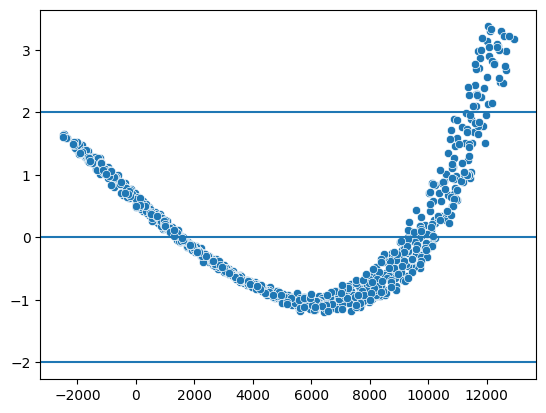

In [186]:
#Verificar linearidade dos residuos: valores entre -2 e +2 na escala padrão
# Verificar homocedasticidade, valores em torno da reta sem tendencia ou formato
sns.scatterplot(x=y_pred_total, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=-2)
plt.axhline(y=2)

Valores dos residuos seguem uma certa "tendencia" não linear, varios valores acima do 2

indicador de que nao existe linearidade e nem homocedasticidade

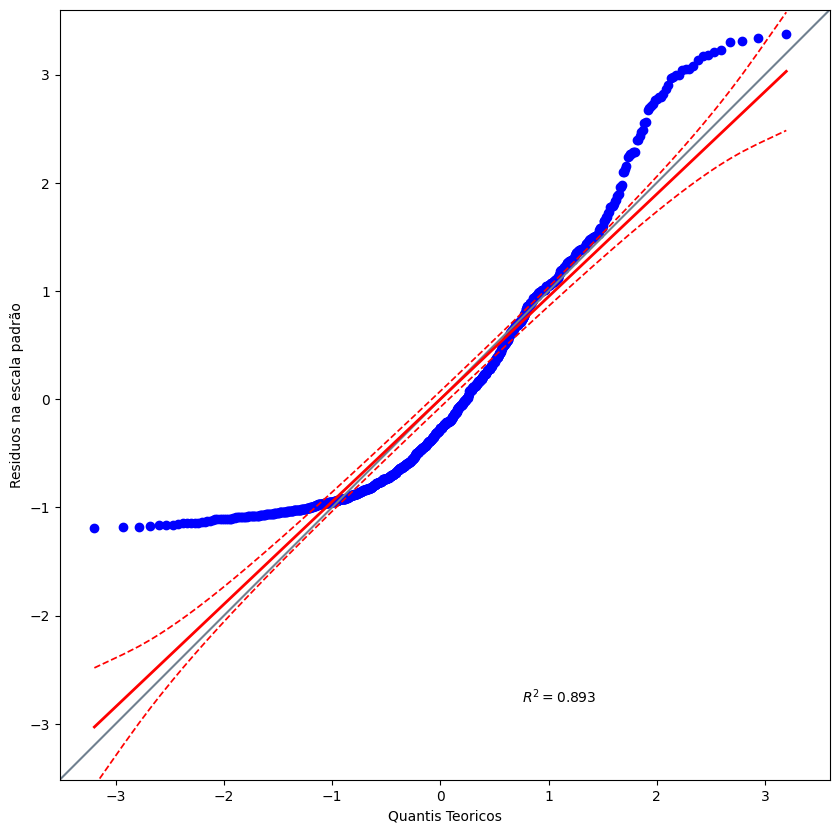

In [187]:
#Checar se residuos seguem uma distribuição normal
plt.figure(figsize=(10,10))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teoricos')
plt.ylabel('Residuos na escala padrão')
plt.show()

Graficamente tambem nao aparente existir uma distribuição normal nos residuos, modelo nao esta ok

In [188]:
# teste de normalidade - shapiro-wilk
stat_shapiro, p_value_shapiro = shapiro(residuos)
print(f'Estatistica do teste: {stat_shapiro} e p-value: {p_value_shapiro}')

Estatistica do teste: 0.891969217965228 e p-value: 7.013497918013492e-26


P-value muito baixo, menor do que 0.005 Residuos nao seguem distribuição normal, testaremos com outros metodos para confirmar a hipotese

In [189]:
stat_kolmogorov, p_value_kolmogorov = kstest(residuos, 'norm')
print(f'Estatistica do teste: {stat_kolmogorov} e p-value: {p_value_kolmogorov}')

Estatistica do teste: 0.5939999999999955 e p-value: 0.0


P-value tambem abaixo de 0.005, confirmando nossa hipotese

In [190]:
stat_ll, pvalue_ll = lilliefors(residuos, dist='norm', pvalmethod='table')
print(f'Estatistica do teste {stat_ll} e p-value: {pvalue_ll}')

Estatistica do teste 0.11825983774680088 e p-value: 0.0009999999999998899


p-value abaixo de 0.005 confirma nossa hipotese novamente
modelo nao esta ok

alterar modelo

### TREINAR MODELO POLINOMIAL

In [191]:
#Criação de features polinomiais
feat_poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = feat_poly.fit_transform(X)
feat_poly.feature_names_in_

array(['tempo_na_empresa', 'nivel_na_empresa'], dtype=object)

In [192]:
feat_poly.get_feature_names_out(feat_poly.feature_names_in_)

array(['tempo_na_empresa', 'nivel_na_empresa', 'tempo_na_empresa^2',
       'tempo_na_empresa nivel_na_empresa', 'nivel_na_empresa^2',
       'tempo_na_empresa^3', 'tempo_na_empresa^2 nivel_na_empresa',
       'tempo_na_empresa nivel_na_empresa^2', 'nivel_na_empresa^3'],
      dtype=object)

In [193]:
#Bloco para treinamento do modelo

#graus_polinomial = [1,2,3,4,5,6,7,8,9,10]
graus_polinomial  = [4]
rmse_train_values = []
rmse_test_values = []
percentual_rmse_values = []
r2score_test_values = []

#Split usando kfold com 5 pastas/splits
kf = KFold(n_splits=5,shuffle=True, random_state=51)

for grau in graus_polinomial:
        
    #Pipeline
    #Padronizar variaveis numericas - tempo na empresa, nivel na empresa

    #Nomes das colunas
    colunas_numericas = ['tempo_na_empresa','nivel_na_empresa']

    #Transformer para colunas numericas
    transformer_numericas = Pipeline(steps=[('scaler',StandardScaler()) ])

    #Criar um Column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', transformer_numericas, colunas_numericas)
        ]
    )
    #criar features polinomiais
    poly_feat = PolynomialFeatures(degree=grau, include_bias=False)

    #Criando o Pipeline principal - Preprocessamento + Treinamento
    model_poly = Pipeline(steps =[
        ('preprocessor', preprocessor),
        ('poly_features', poly_feat),
        ('regressor', LinearRegression())
        ])

    #Armazenas RMSE treino e teste (root mean squared error)
    rmse_scores_fold_train = []
    rmse_scores_fold_teste = []

    #Armazenar o r2-score de teste
    r2_score_fold_test = []

    #Armazenar Residuos
    residuos = []

    #Armazenar predições
    y_pred_total = []

    #iteração separação de modelo em x e y train e test
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        #Treine o modelo no conjunto de treinamento
        model_poly.fit(X_train, y_train)

        #Faça predições nos conjuntos de treinamento e teste
        y_train_pred = model_poly.predict(X_train)
        y_test_pred = model_poly.predict(X_test)
        
        #Calcule o rmse para os conjuntos de treinamento  e teste
        rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
        rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
        r2score_test = r2_score(y_test,y_test_pred)
        residuos_test = np.array(y_test - y_test_pred)

        #Armazenar resultados
        rmse_scores_fold_train.append(rmse_train)
        rmse_scores_fold_teste.append(rmse_test)
        r2_score_fold_test.append(r2score_test)
        residuos.append(residuos_test)
        y_pred_total.append(y_test_pred)

    rmse_train_final = np.mean(rmse_scores_fold_train)
    rmse_test_final = np.mean(rmse_scores_fold_teste)
    r2_score_final = np.mean(r2_score_fold_test)
    percentual_rmse_final = ((rmse_test_final - rmse_train_final) / rmse_train_final)*100
    residuos = np.array(residuos).reshape(-1)
    y_pred_total = np.array(y_pred_total).reshape(-1)

    rmse_train_values.append(rmse_train_final)
    rmse_test_values.append(rmse_test_final)
    r2score_test_values.append(r2_score_final)
    percentual_rmse_values.append(percentual_rmse_final)


/home/nicolas-giacomelli/.local/share/virtualenvs/Regressao_polinomial-B8JKqZNf/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nicolas-giacomelli/.local/share/virtualenvs/Regressao_polinomial-B8JKqZNf/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nicolas-giacomelli/.local/share/virtualenvs/Regressao_polinomial-B8JKqZNf/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nicolas

In [194]:
''' #Plotar grafico para comparar RMSE por grau de polinomio
plt.figure(figsize=(12,8))
plt.plot(graus_polinomial, rmse_train_values, label='RMSE (Treino)')
plt.plot(graus_polinomial, rmse_test_values, label='RMSE (Teste)')
plt.xlabel('Grau do polinomio')
plt.ylabel('RMSE')
plt.title('RMSE por Grau de Polinomio')
plt.legend()
plt.grid(True)
plt.show '''

" #Plotar grafico para comparar RMSE por grau de polinomio\nplt.figure(figsize=(12,8))\nplt.plot(graus_polinomial, rmse_train_values, label='RMSE (Treino)')\nplt.plot(graus_polinomial, rmse_test_values, label='RMSE (Teste)')\nplt.xlabel('Grau do polinomio')\nplt.ylabel('RMSE')\nplt.title('RMSE por Grau de Polinomio')\nplt.legend()\nplt.grid(True)\nplt.show "

Pelo grafico nao conseguimos identificar overfitting, valores muito proximos

In [195]:
''' #Plotar grafico para comparar percentual diferenca de rmse treino - teste
plt.figure(figsize=(12,8))
plt.plot(graus_polinomial, percentual_rmse_values, label='%Dif RMSE')
plt.xlabel('Grau do polinomio')
plt.ylabel('% Dif RMSE')
plt.title('% Dif RMSE por Grau de Polinomio')
plt.legend()
plt.grid(True)
plt.show '''

" #Plotar grafico para comparar percentual diferenca de rmse treino - teste\nplt.figure(figsize=(12,8))\nplt.plot(graus_polinomial, percentual_rmse_values, label='%Dif RMSE')\nplt.xlabel('Grau do polinomio')\nplt.ylabel('% Dif RMSE')\nplt.title('% Dif RMSE por Grau de Polinomio')\nplt.legend()\nplt.grid(True)\nplt.show "

não vale a pena utilizar graus de polinomio muito altos, começa a ter risco de overfittin, escolhido utilizar 4 graus

### ANALISE DE METRICAS POLINOMIAL

In [196]:
# Metricas
print(f'RMSE Treino: {rmse_train_final}')
print(f'RMSE Teste: {rmse_test_final}')
print(f'% Dif. RMSE treino teste: {percentual_rmse_final}')
print(f'R2Score Teste: {r2_score_final}')

RMSE Treino: 53.32698559565159
RMSE Teste: 54.70504352796338
% Dif. RMSE treino teste: 2.584166190755325
R2Score Teste: 0.9998524123039415


### ANALISE DE RESIDUOS MODELO POLINOMIAL

In [197]:
#Transformar residuos na escala padrão
#(x-media)/desvio padrão
residuos_std = zscore(residuos)

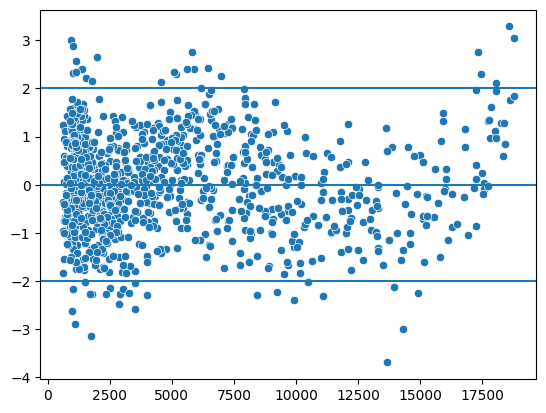

In [198]:

#Verificar linearidade dos residuos: valores entre -2 e +2 na escala padrão
# Verificar homocedasticidade, valores em torno da reta sem tendencia ou formato
sns.scatterplot(x=y_pred_total, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=-2)
plt.axhline(y=2)

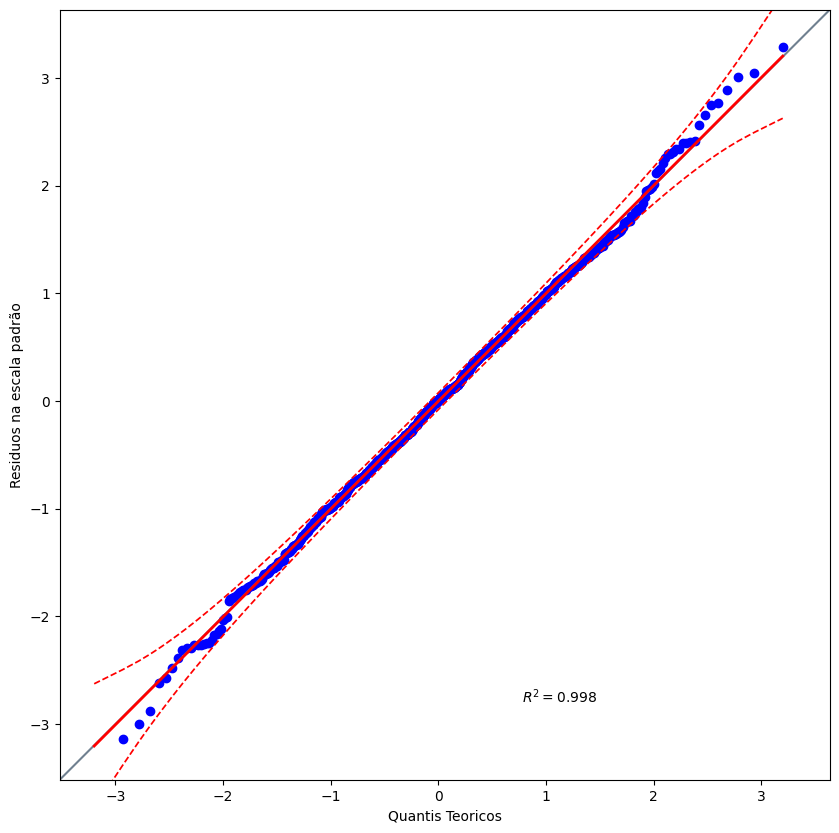

In [199]:

#Checar se residuos seguem uma distribuição normal
plt.figure(figsize=(10,10))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teoricos')
plt.ylabel('Residuos na escala padrão')
plt.show()

Valores muito mais ajustados a reta, alguns pontos proximos das bandas mas ok

In [200]:
# teste de normalidade - shapiro-wilk
stat_shapiro, p_value_shapiro = shapiro(residuos)
print(f'Estatistica do teste: {stat_shapiro} e p-value: {p_value_shapiro}')

Estatistica do teste: 0.9986951372205289 e p-value: 0.6852797159638004


pvalue maior que 0.005 segue distribuição normal

In [201]:
stat_kolmogorov, p_value_kolmogorov = kstest(residuos, 'norm')
print(f'Estatistica do teste: {stat_kolmogorov} e p-value: {p_value_kolmogorov}')

Estatistica do teste: 0.4823744649953392 e p-value: 1.2202460105710526e-214


confirma a hipotese do teste de shapiro

In [202]:
stat_ll, pvalue_ll = lilliefors(residuos, dist='norm', pvalmethod='table')
print(f'Estatistica do teste {stat_ll} e p-value: {pvalue_ll}')

Estatistica do teste 0.013637346894973312 e p-value: 0.956627002204744


Confirma os dois testes anteriores, modelo segue distribuição normal

### PREDIÇÃO INDIVIDUAL

In [203]:
input_features = {
    'tempo_na_empresa':72,
    'nivel_na_empresa':10
}

pred_df = pd.DataFrame(input_features, index=[1])

In [204]:
#predição
model_poly.predict(pred_df)

array([4808.03154228])

In [206]:
#salvar Modelo
joblib.dump(model_poly, './modelo_salario.pkl')

['./modelo_salario.pkl']